In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, torch, pickle, random
sys.path.append('../models')
from lstm_model import LSTMModel
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

In [3]:
### 코골이 모델 준비
generalization_value = 200
snoring_model_file = '../models/snoring_model.pkl'
snoring_model = pickle.load(open(snoring_model_file, 'rb'))


### 호흡분석 모델, 심박분석 모델 준비
hidden_size = 50
num_layers = 1

# 호흡 모델 및 스케일러 불러오기
with open('../models/breath_scaler.pkl', 'rb') as f:
    breath_scaler = pickle.load(f)
breath_model_file = '../models/lstm_breath_model.pth'
breath_model = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=1)
breath_model.load_state_dict(torch.load(breath_model_file))
breath_model = breath_model.eval()

# 심박 모델 및 스케일러 불러오기
with open('../models/heartbeat_scaler.pkl', 'rb') as f:
    heartbeat_scaler = pickle.load(f)
heartbeat_model_file = '../models/lstm_heartbeat_model.pth'
heartbeat_model = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=1)

C:\Users\gistk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\gistk\AppData\Local\Temp\ipykernel_5124\3342797912.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This l

In [4]:
## 코골이 모델 예측 함수
def event_indices_to_ranges(indices, hold_step=10):
    start_index = 0
    index_ranges = []
    for i in indices:
        if start_index == 0:
            start_index = i
            previous_index = i
            continue
        if i - previous_index < hold_step:
            previous_index = i
        else:
            index_ranges.append((start_index-1, previous_index)) # diff를 구할 때 index가 하나씩 밀리므로 -1해줌
            start_index = i
            previous_index = i
        if i == indices[-1]:
            index_ranges.append((start_index, i))
    return index_ranges

def analyze_snoring(sound, model, check_time=4, interval=2, sound_threshold=3):
    # sound가 checktime 이상 조용할 때를 수면에 들기 전단계로 판단
    max_queue_size = check_time / interval 
    queue = []
    sleep_ready_index = None
    for i in range(len(sound)):
        if len(queue) != max_queue_size:
            queue.append(sound[i])
        else:
            if sum(queue)/max_queue_size < sound_threshold:
                sleep_ready_index = i
                break
            else:
                queue.pop(0)
                queue.append(sound[i])
    X = []
    if sleep_ready_index == None:
        print("Warning: No sleep ready index")
        sleep_ready_index = 0
    for i in range(sleep_ready_index, len(sound)-5, 5):
        X.append(np.array(sound[i:i+5].values))
    # 모델을 이용한 코골이 판단
    predict = model.predict(X)
    # 모델 index는 5개씩 묶음이고 코콜이 유무므로 다시 1개씩으로 변환
    snoring = [0]*len(sound)
    for i, pred in enumerate(predict):
        for j in range(5):
            snoring[sleep_ready_index + i*5 + j] = pred
    # 코골이한 구간만 추출
    snoring_index = np.where(np.array(snoring) == 1)[0]
    res = event_indices_to_ranges(snoring_index, hold_step=3)

    # 전체 코골이 시간 추출
    total_snoring_time = 0
    for i in res:
        total_snoring_time = total_snoring_time + 2*(i[1] - i[0])
        
    # 1분 이상 코골이 구간 추출
    over_1min_snoring_ranges = list(filter(lambda x: x[1] - x[0] >= 30, res))
    # print(f"snoring: {total_snoring_time}, {over_1min_snoring_ranges}")

    print(f"snoring_index: {snoring_index}")
    print('res', res)
    print(f"total_snoring_time: {total_snoring_time}, over_1min_snoring_ranges: {over_1min_snoring_ranges}")
    return total_snoring_time, over_1min_snoring_ranges, snoring_index

## LSTM (호흡, 심박) 모델 예측 함수
def lstm_predict(data_nonzero, threshold, scale_model, lstm_model):
    scaled_data = scale_model.transform(data_nonzero.values.reshape(-1, 1)).reshape(-1)
    with torch.no_grad():
        predict = lstm_model(torch.tensor(scaled_data).float().view(-1, 1, 1))
    expected = scale_model.inverse_transform(predict.view(-1).numpy().reshape(-1, 1)).reshape(-1)
    result = np.abs((expected - data_nonzero.values)/data_nonzero.values) <= threshold
    return result

snoring_index: []
res []
total_snoring_time: 0, over_1min_snoring_ranges: []


C:\Users\gistk\AppData\Local\Temp\ipykernel_5124\2876179576.py:34: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  feature_df['breath_stable'].iloc[nonzero_breath.index] = breath_stable_predict
C:\Users\gistk\AppData\Local\Temp\ipykernel_5124\

총 개수: 995
1인 값의 개수: 425
1인 값의 인덱스: [  0   1   2   3   4   5   6   7   8   9  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255 256 257

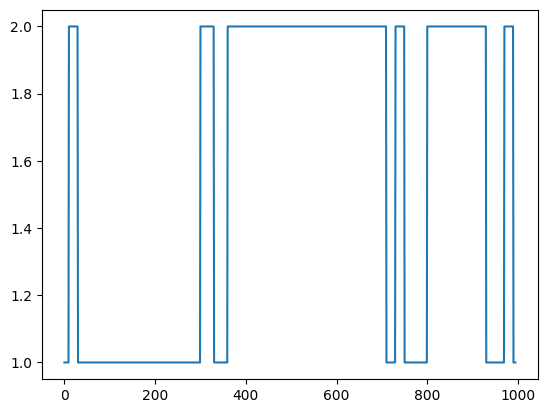

In [7]:
import time
## 실제 센서 값 가져와서 분석하기 

# 수면 판정 파라미터
window_size = 20
sliding_window = 10
large_move_threshold = 10
breath_stable_threshold = 0.2
breath_stable_count_thres = 6
heartbeat_stable_threshold = 0.2
heartbeat_stable_count_thres = 12
default_sleep_state = 1 # 수면 상태: 1 얕은 수면, 2 깊은 수면


## 수면 판정 시작
flag_move_large = []
breath_idx = []
heartbeat_idx = []
# feature_df = pd.read_csv('../tests/data/realtime_data_test_prepared.csv')
feature_df = pd.read_csv('../tests/data/fake/interval_1.csv')


# print(feature_df['sleep_state'])

start_time = time.time()

# 모델을 이용한 코골이 판정
total_snoring_time, over_1min_snoring_ranges, snoring_index = analyze_snoring(feature_df['sound_value']/generalization_value, snoring_model)

# 모델을 이용한 호흡판정
nonzero_breath = feature_df[feature_df['breath_rate'] != 0]
breath_stable_predict = lstm_predict(nonzero_breath['breath_rate'], breath_stable_threshold, breath_scaler, breath_model)
feature_df['breath_stable'] = np.nan
feature_df['breath_stable'].iloc[nonzero_breath.index] = breath_stable_predict

# 모델을 이용한 심박판정
nonzero_heartbeat = feature_df[feature_df['heart_rate'] != 0]
heartbeat_stable_predict = lstm_predict(nonzero_heartbeat['heart_rate'], heartbeat_stable_threshold, heartbeat_scaler, heartbeat_model)
feature_df['heartbeat_stable'] = np.nan
feature_df['heartbeat_stable'].iloc[nonzero_heartbeat.index] = heartbeat_stable_predict

sleep = np.zeros(len(feature_df))
for i in range(0, len(feature_df), sliding_window):
    snore = False
    for j in range(i, sliding_window):
        # 1. 코골이가 있는 경우
        if j in snoring_index:
            sleep[i:i+sliding_window] = 2
            snore = True
            break
    if snore:
        continue
    # 2. 움직임이 큰 경우
    if feature_df['move_value'].iloc[i:i+window_size].mean() > large_move_threshold:
        sleep[i:i+sliding_window] = default_sleep_state
    elif feature_df['heart_rate'].iloc[i:i+window_size].where(feature_df['heart_rate'] != 0).count() == 0:
        sleep[i:i+sliding_window] = sleep[i-1] if i != 0 else default_sleep_state
    # 3. 심박이 안정한 경우
    elif feature_df['heartbeat_stable'].iloc[i:i+window_size].where(feature_df['heartbeat_stable'] == True).count() > heartbeat_stable_count_thres:
        sleep[i:i+sliding_window] = 2
    # 4. 호흡이 안정한 경우
    elif feature_df['breath_stable'].iloc[i:i+window_size].where(feature_df['breath_stable'] == True).count() > breath_stable_count_thres:
        sleep[i:i+sliding_window] = 1
    else:
        sleep[i:i+sliding_window] = default_sleep_state

# 총 개수
# total_count = len(sleep)
# print(f"총 개수: {total_count}")

# # 방법 1: 0인 값의 개수 확인
# zero_count = np.count_nonzero(sleep == 1)
# print(f"1인 값의 개수: {zero_count}")

# # 방법 2: 0인 값의 인덱스 확인
# zero_indices = np.where(sleep == 1)[0]
# print(f"1인 값의 인덱스: {zero_indices}")

# # 방법 1: 0인 값의 개수 확인
# zero_count1 = np.count_nonzero(sleep == 2)
# print(f"2인 값의 개수: {zero_count1}")

# # 방법 2: 0인 값의 인덱스 확인
# zero_indices1 = np.where(sleep == 2)[0]
# print(f"2인 값의 인덱스: {zero_indices1}")


# print(f"Time: {time.time() - start_time}")
# 각 측정 포인트 별 수면 판정 결과 그래프로 표시
plt.plot(sleep)
plt.show()

        day       hour        min  sleep_mode
count  30.0  30.000000  30.000000   30.000000
mean    9.0   5.600000  26.500000    1.600000
std     0.0   0.498273  22.899706    0.498273
min     9.0   5.000000   0.000000    1.000000
25%     9.0   5.000000   7.250000    1.000000
50%     9.0   6.000000  14.500000    2.000000
75%     9.0   6.000000  51.750000    2.000000
max     9.0   6.000000  59.000000    2.000000


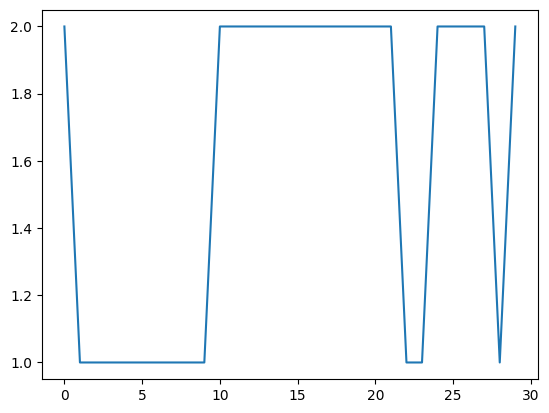

In [5]:
# 정답지와 비교를 위해 분단위로 변환
predict_df = pd.DataFrame()
predict_df['day'] = feature_df['day']
predict_df['hour'] = feature_df['hour']
predict_df['min'] = feature_df['min']
predict_df['sleep_mode'] = sleep
# 수면 판정 결과를 분단위로 묶어 최빈값으로 변환, 이 때 최빈값이 2개 이상인 경우 직전 값으로 변환
predict_df = predict_df.groupby(['day', 'hour', 'min'])['sleep_mode'].agg(pd.Series.mode).reset_index()
def is_np_array(value):
    if type(value) == np.ndarray:
        return True
    else:
        return False
for index, row in predict_df.iterrows():
    if is_np_array(row['sleep_mode']):
        predict_df.loc[index, 'sleep_mode'] = predict_df.loc[index-1, 'sleep_mode']
    assert not is_np_array(predict_df.loc[index, 'sleep_mode']), f"np array: {predict_df.loc[index, 'sleep_mode']}"
    
predict_df['sleep_mode'] = predict_df['sleep_mode'].values.astype(int)

print(predict_df.describe())
plt.plot(predict_df['sleep_mode'])
plt.show()


       sleep_mode
count  283.000000
mean     1.724382
std      0.447617
min      1.000000
25%      1.000000
50%      2.000000
75%      2.000000
max      2.000000


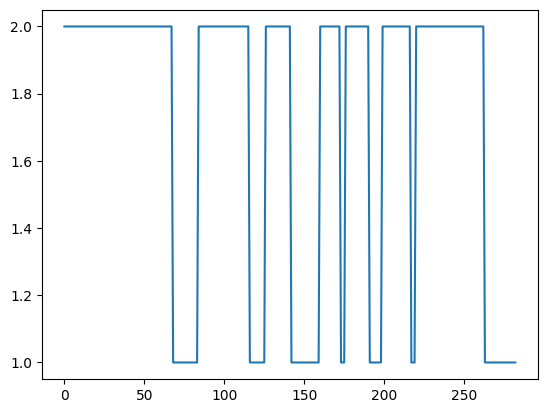

In [7]:
# 정답지 불러오기
truth_df = pd.read_csv('../tests/data/watch_data_test_prepared.csv')
print(truth_df.describe())
plt.plot(truth_df['sleep_mode'])
plt.show()

In [8]:
# 정확도 계산
def caculate_accuracy(predict_df, truth_df):
    class_1_count = 0; class_1_correct = 0; class_1_false = 0
    class_2_count = 0; class_2_correct = 0; class_2_false = 0
    for index, row in truth_df.iterrows():
        if row['sleep_mode'] == 1:
            class_1_count += 1
            if row['sleep_mode'] == predict_df.iloc[index]['sleep_mode']:
                class_1_correct += 1
            else:
                class_1_false += 1
        elif row['sleep_mode'] == 2:
            class_2_count += 1
            if row['sleep_mode'] == predict_df.iloc[index]['sleep_mode']:
                class_2_correct += 1
            else:
                class_2_false += 1
    return class_1_count, class_1_correct, class_1_false, class_2_count, class_2_correct, class_2_false

class_1_count, class_1_correct, class_1_false, class_2_count, class_2_correct, class_2_false = caculate_accuracy(predict_df, truth_df)
print("Class 1 (Light sleep)")
print(f"Count: {class_1_count}, Correct: {class_1_correct}, False: {class_1_false}")
print(f"Accuracy(IoU): {class_1_correct/class_1_count}")
print()
print("Class 2 (Deep sleep)")
print(f"Count: {class_2_count}, Correct: {class_2_correct}, False: {class_2_false}")
print(f"Accuracy(IoU): {class_2_correct/class_2_count}")

Class 1 (Light sleep)
Count: 78, Correct: 62, False: 16
Accuracy(IoU): 0.7948717948717948

Class 2 (Deep sleep)
Count: 205, Correct: 145, False: 60
Accuracy(IoU): 0.7073170731707317


In [8]:
# predict 결과값 csv로 저장
predict_df['testtime'] = '2024-10-' + predict_df['day'].map('{:02d}'.format) + ' ' + predict_df['hour'].map('{:02d}'.format) + ':' + predict_df['min'].map('{:02d}'.format)
predict_df[['testtime', 'sleep_mode']].to_csv('../tests/result/predict_sleep_mode.csv', index=False)